In [1]:
# MISC
import os
import sys
import functools
sys.path.append("..")

os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

from rich.pretty import pprint

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# RL 
import jax
import jax.numpy as jnp
import gymnasium
import ogbench
import ogbench.online_locomotion.wrappers
import flax.linen as nn

# Custom
from envs.ogbench.ant_utils import MazeVizWrapper, plot_value
from utils.datasets import Dataset, GCDataset
from agents.fb import ForwardBackwardAgent

from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

GLOBAL_KEY = jax.random.key(42)

GLOBAL_KEY = jax.random.key(42)

# Use either exising dataset or create from data_gen_scripts
# 'pointmaze-medium-explore-v0'
# env = ogbench.make_env_and_datasets( #  train_dataset, valid_dataset 
#     "pointmaze-medium-explore-v0",
#     env_only=True, render_mode='rgb_array'
# )

# env, train_dataset, valid_dataset = ogbench.make_env_and_datasets( #  train_dataset, valid_dataset 
#     "pointmaze-medium-stitch-v0",
#     env_only=False
# )

# obs, info = env.reset()
# env = MazeVizWrapper(env)
# train_dataset = Dataset.create(**train_dataset)
# fig, ax = plt.subplots()

# polygons = env.draw(ax=ax)
# ax.scatter(train_dataset['observations'][:, 0], train_dataset['observations'][:, 1])

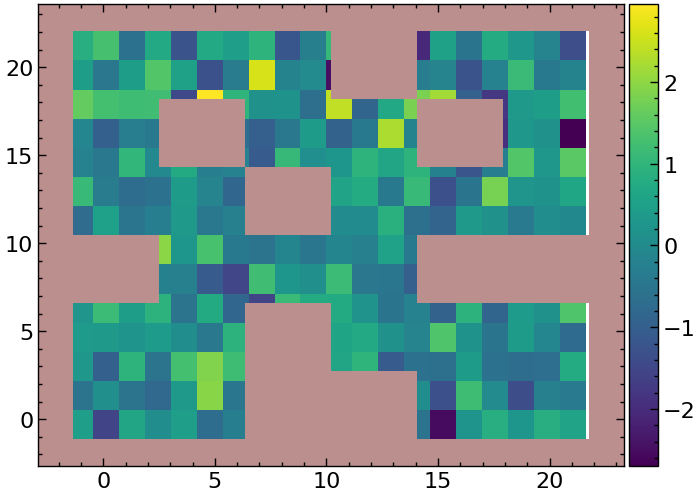

In [2]:
fig, ax = plt.subplots()
ax.scatter(*info['goal'], c='red')
plot_value(env, train_dataset, value_fn=lambda x: np.random.normal(size=x.shape[0]), fig=fig, ax=ax)

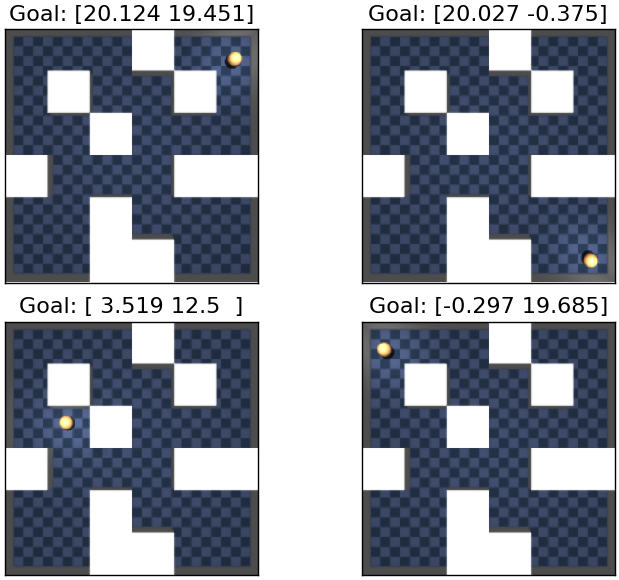

In [5]:
fig, axs = plt.subplots(ncols=2, nrows=2)
axs = axs.flatten()
for idx, task_id in enumerate([1, 2, 3, 4]):
    ob, info = env.reset(
        options=dict(
            task_id=task_id,
            render_goal=True,
        )
    )
    goal = info['goal']
    goal_rendered = info['goal_rendered']
    axs[idx].imshow(goal_rendered)
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
    axs[idx].set_title(f"Goal: {np.round(goal, 3)}")
plt.tight_layout()

In [2]:
from ogbench.utils import load_dataset

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = []
NUM_TRAIN_LAYOUTS = 3

for i in range(1, NUM_TRAIN_LAYOUTS + 1):
    cur_data = load_dataset(f"/home/m_bobrin/ZeroShotRL/aux_data/pointmaze-layout{i}.npz")
    whole_data.append(cur_data)

whole_data = functools.reduce(concatenate_dicts, whole_data)
whole_data['observations'] = whole_data['observations'].reshape(-1, 100, 2)
whole_data['actions'] = whole_data['actions'].reshape(-1, 100, 2)
whole_data['next_observations'] = whole_data['next_observations'].reshape(-1, 100, 2)
whole_data['terminals'] = whole_data['terminals'].reshape(-1, 100, 1)

pprint(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))

env = gymnasium.make("pointmaze-medium-layout1", render_mode='rgb_array')
env = MazeVizWrapper(env)
ob, info = env.reset()

{
│   'actions': (600, 100, 2),
│   'next_observations': (600, 100, 2),
│   'observations': (600, 100, 2),
│   'terminals': (600, 100, 1)
}

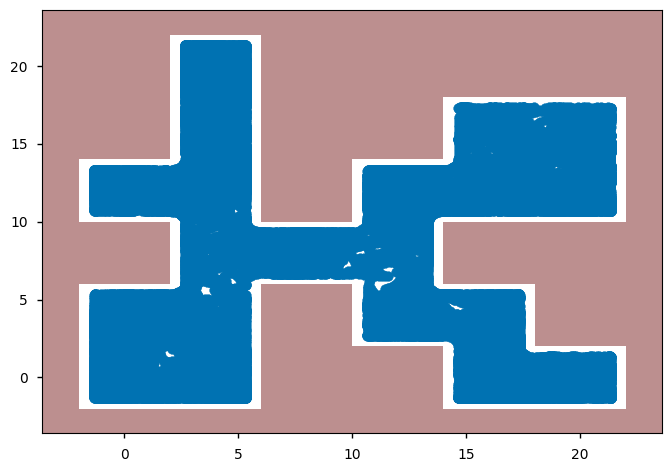

In [3]:
fig, ax = plt.subplots()
polygons = env.draw(ax=ax)
ax.scatter(whole_dataset['observations'].reshape(-1, 2)[:20_000, 0], whole_dataset['observations'].reshape(-1, 2)[:20_000, 1])

In [4]:
from utils.transformer_nets import DynamicsTransformer, NextStatePrediction
from utils.flax_utils import TrainState, ModuleDict
import optax
from sklearn.manifold import TSNE

example_batch = whole_dataset.sample(1)
next_state_pred_def = NextStatePrediction(hidden_dims=(128, 128, 128), out_dim=example_batch['observations'].shape[-1])
dynamics_def = DynamicsTransformer(
    num_layers=4,
    num_heads=4,
    out_dim=2,
    action_dim=example_batch['actions'].shape[-1],
    causal=False,
    emb_dim=96,
    mlp_dim=256,
    dropout_rate=0.0,
    attention_dropout_rate=0.0,
    context_len=example_batch['observations'].shape[1]
)
key, init_rng = jax.random.split(GLOBAL_KEY)
network_tx = optax.chain(
    optax.clip_by_global_norm(1.0), optax.adam(learning_rate=3e-4))

network_info = dict()
network_info.update(
                dynamic_transformer=(dynamics_def, (example_batch['observations'], example_batch['actions'],
                                                    example_batch['next_observations'], True))
)
network_info.update(
    next_state_pred=(next_state_pred_def, (example_batch['observations'], example_batch['actions'], jnp.zeros((1, dynamics_def.context_len, dynamics_def.out_dim))))
)
networks = {k: v[0] for k, v in network_info.items()}
network_args = {k: v[1] for k, v in network_info.items()}
network_def = ModuleDict(networks)
network_params = network_def.init(init_rng, **network_args)['params']
network = TrainState.create(network_def, network_params, tx=network_tx)

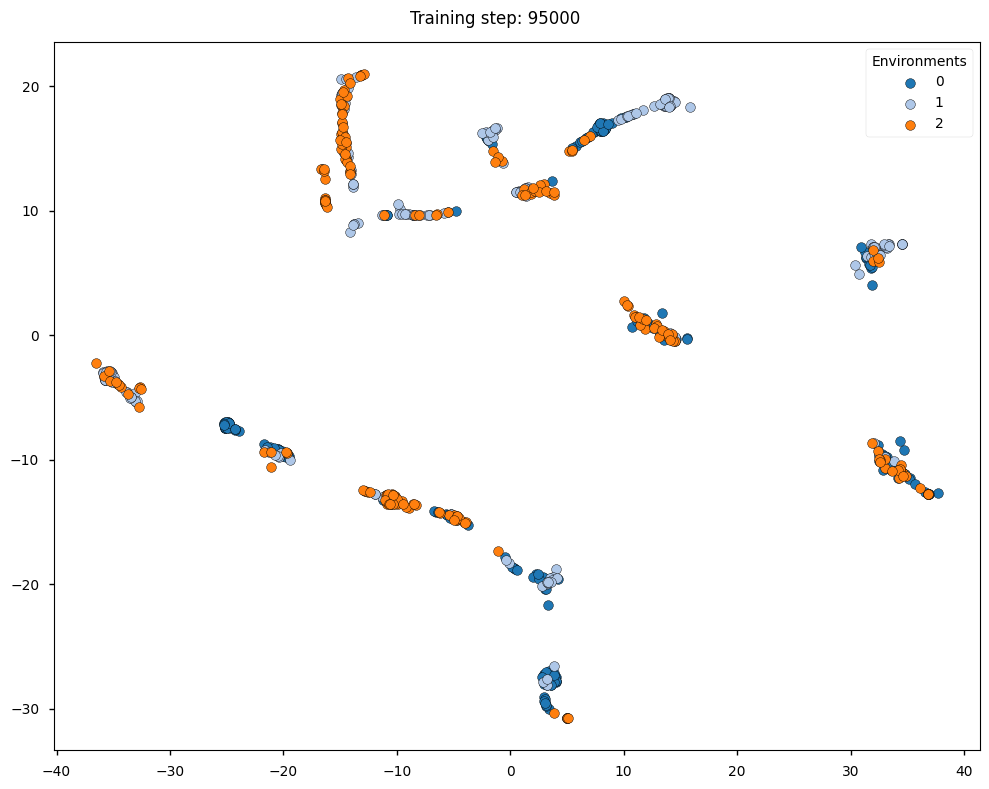

In [6]:
from IPython.display import clear_output
from tqdm.auto import tqdm

def context_encoder_loss(agent, batch, grad_params, rng):
    dynamics_embedding_mean, dynamics_embedding_std = agent.select('dynamic_transformer')(batch['observations'], batch['actions'],
                                                                            batch['next_observations'], train=True, params=grad_params)
    dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=rng, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_embedding_std)
    dynamics_embedding = jnp.tile(dynamics_embedding[:, None], reps=(1, batch['next_observations'].shape[1], 1))
    next_state_pred = agent.select('next_state_pred')(batch['observations'], batch['actions'], dynamics_embedding, params=grad_params)
    loss = optax.squared_error(next_state_pred, batch['next_observations']).mean()
    return loss, {"context_embedding_loss": loss}

@jax.jit
def update(agent, batch, rng):
    def loss_fn(grad_params):
        return context_encoder_loss(agent, batch, grad_params, rng)
    
    agent, info = agent.apply_loss_fn(loss_fn)
    return agent, info

num_environments = 3
samples_per_env = 200

# Generate colors automatically
env_indices = np.repeat(np.arange(num_environments), samples_per_env)

# Learn transformer
pbar = tqdm(range(100_000))
for update_step in pbar:
    update_key = jax.random.fold_in(GLOBAL_KEY, i)
    batch = whole_dataset.sample(512)
    network, info = update(network, batch, update_key)
    
    if update_step % 5_000 == 0:
        clear_output()
        dynamics_embedding_mean, dynamics_embedding_std = network.select('dynamic_transformer')(whole_data['observations'], whole_data['actions'],
                                                                            whole_data['next_observations'], train=False)
        dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=update_key, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_embedding_std)
        tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
        fig, ax = plt.subplots(figsize=(10, 8))
        for i in range(num_environments):
            mask = (env_indices == i)
            ax.scatter(tsne[mask, 0], tsne[mask, 1], 
                        color=plt.cm.tab20(i), 
                        edgecolors='black',
                        label=i,
                        alpha=1.0)
            
        fig.suptitle(f"Training step: {update_step}")
        ax.legend(title="Environments")
        plt.tight_layout()
        display(fig)
        plt.close(fig)
        

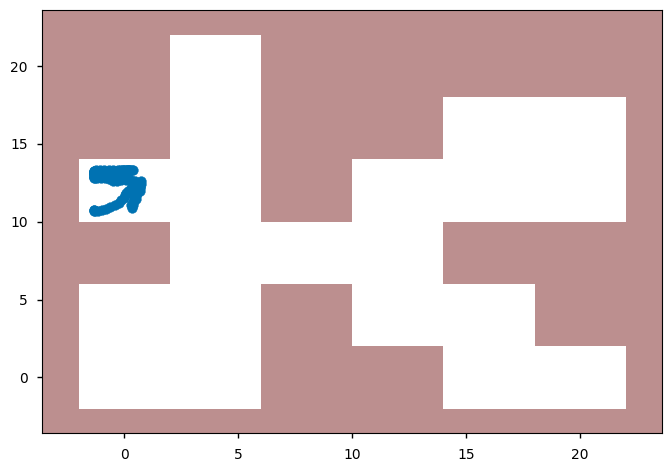

In [34]:
env = gymnasium.make("pointmaze-medium-layout1", render_mode='rgb_array')
env = MazeVizWrapper(env)
ob, info = env.reset()

fig, ax = plt.subplots()
polygons = env.draw(ax=ax)
ax.scatter(whole_dataset['observations'][150].reshape(-1, 2)[:, 0], whole_dataset['observations'][150].reshape(-1, 2)[:, 1])

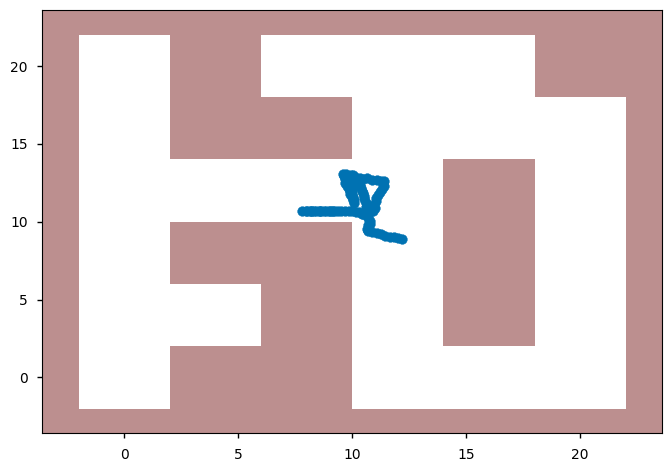

In [33]:
env = gymnasium.make("pointmaze-medium-layout2", render_mode='rgb_array')
env = MazeVizWrapper(env)
ob, info = env.reset()

fig, ax = plt.subplots()
polygons = env.draw(ax=ax)
ax.scatter(whole_dataset['observations'][450].reshape(-1, 2)[:, 0], whole_dataset['observations'][450].reshape(-1, 2)[:, 1])

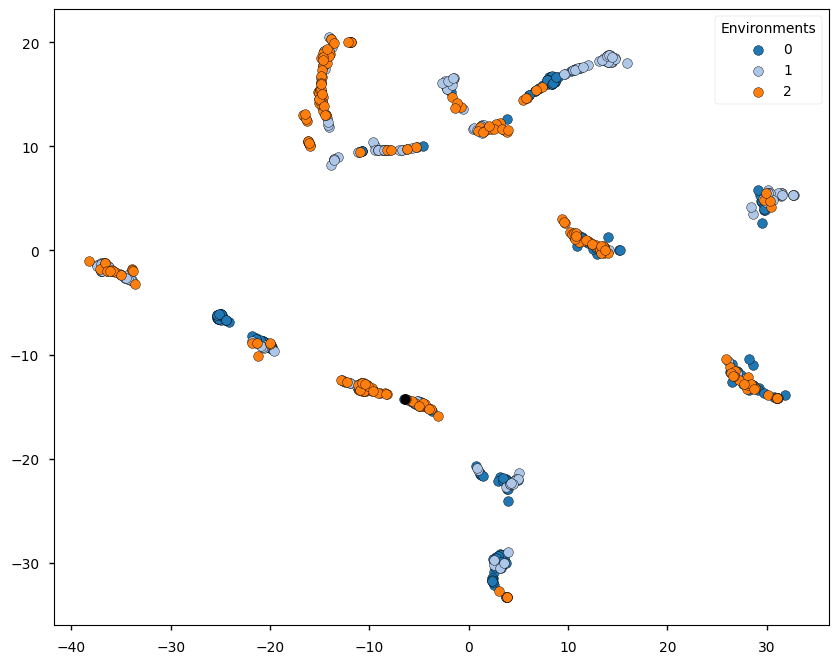

In [32]:
layout2 = whole_dataset.get_subset(450)
layout1 = whole_dataset.get_subset(150)

test_new_obs = jnp.concatenate([whole_data['observations'], layout1['observations'][None]])
test_new_acts = jnp.concatenate([whole_data['actions'], layout1['actions'][None]])
test_new_obs_next = jnp.concatenate([whole_data['next_observations'], layout1['next_observations'][None]])

dynamics_embedding_mean, dynamics_embedding_std = network.select('dynamic_transformer')(test_new_obs, test_new_acts,
                                                                            test_new_obs_next, train=False)
dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=update_key, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_embedding_std)

tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(num_environments):
    mask = (env_indices == i)
    ax.scatter(tsne[:-1][mask, 0], tsne[:-1][mask, 1], 
                color=plt.cm.tab20(i), 
                edgecolors='black',
                label=i,
                alpha=1.0)
ax.legend(title="Environments")
ax.scatter(tsne[-1, 0], tsne[-1, 1], color='black')

# Train FB

In [7]:
import functools
from utils.datasets import Dataset, GCDataset

from ogbench.utils import load_dataset

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = []
NUM_TRAIN_LAYOUTS = 3

for i in range(1, NUM_TRAIN_LAYOUTS + 1):
    cur_data = load_dataset(f"/home/m_bobrin/ZeroShotRL/aux_data/pointmaze-layout{i}.npz")
    whole_data.append(cur_data)

whole_data = functools.reduce(concatenate_dicts, whole_data)
pprint(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))

with initialize(version_base=None, config_path="../configs/"):
    fb_config = compose(config_name='entry.yaml', overrides=['experiment=fb_ogbench.yaml'])
    fb_config = OmegaConf.to_container(fb_config, resolve=True)
    pprint(fb_config)

gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])

sys.path.append("..")
from agents.fb import ForwardBackwardAgent

gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])
example_batch = gc_whole_dataset.sample(1)
fb_agent = ForwardBackwardAgent.create(
    0,
    example_batch['observations'],
    example_batch['actions'],
    config=fb_config['agent']
)
batch = gc_whole_dataset.sample(1)
fb_agent, info = fb_agent.update(batch)

{'actions': (60000, 2), 'next_observations': (60000, 2), 'observations': (60000, 2), 'terminals': (60000,)}

{
│   'seed': 42,
│   'run_group': 'fb',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 1000000,
│   'log_interval': 10000,
│   'eval_interval': 100000,
│   'eval_tasks': None,
│   'eval_episodes': 20,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'fb',
│   │   'lr': 0.0003,
│   │   'batch_size': 1024,
│   │   'discrete': False,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'clip_by_global_norm': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.0,
│   │   'value_p_trajgoal': 1.0,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 0.0,
│   │   'actor_p_randomgoal': 1.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'use_context': False,
│   │   'z_dim': 50,
│   │   'z_mix_ratio': 0.5,
│   │   'f_hidden_dims': [1024, 1024, 1024],
│   │   'f_layer_norm': True,
│   │   'f_preprocessor_hidden_dims': [1024, 1024, 512],
│   │   'f_activate_final': False,
│   │   'b_hidden_dims': [512, 512, 512],
│   │   'b_layer_norm': True,
│   │   'actor_hidden_dims': [1024, 1024, 1024],
│   │   'actor_preprocessor_hidden_dims': [1024, 1024, 512],
│   │   'actor_preprocessor_layer_norm': True,
│   │   'actor_preprocessor_activate_final': False,
│   │   'tanh_squash': True,
│   │   'state_dependent_std': False,
│   │   'actor_fc_scale': 0.01,
│   │   'const_std': True
│   },
│   'env': {'env_name': 'ogbench-pointmaze-medium-stitch-v0', 'discrete': False},
│   'tags': ['fb_vanilla', 'ogbench']
}

  0%|          | 0/100000 [00:00<?, ?it/s]

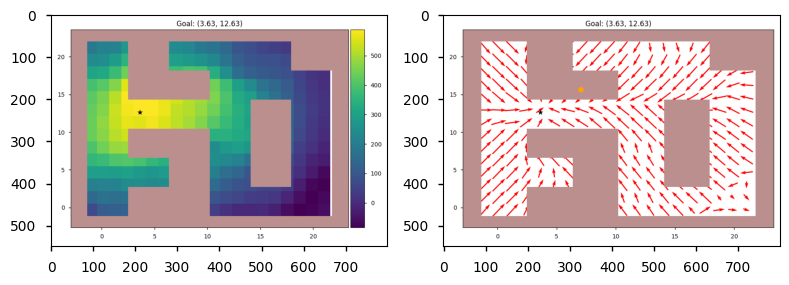

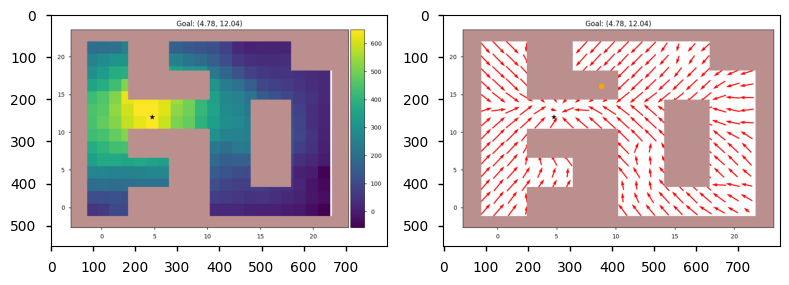

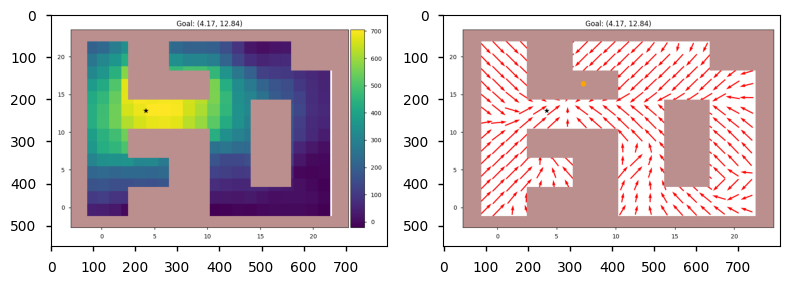

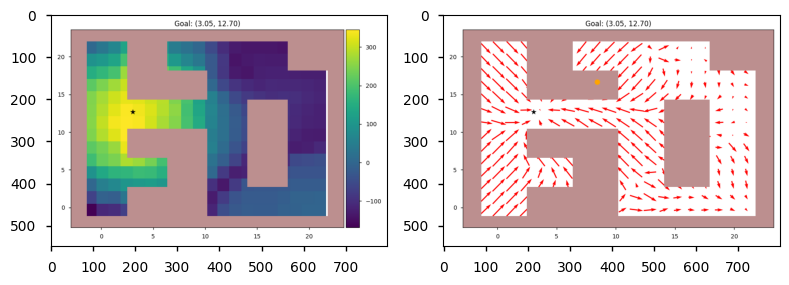

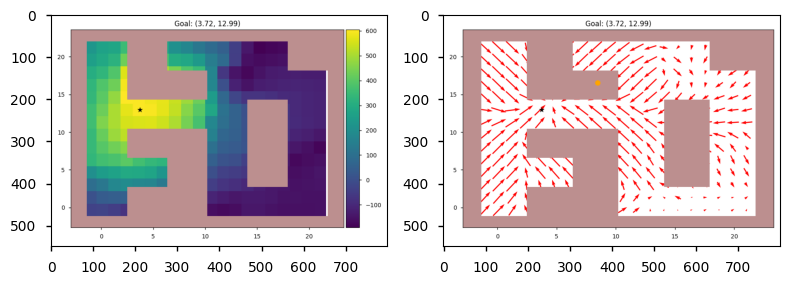

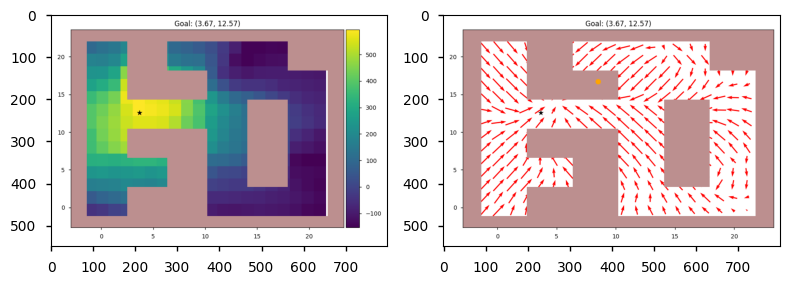

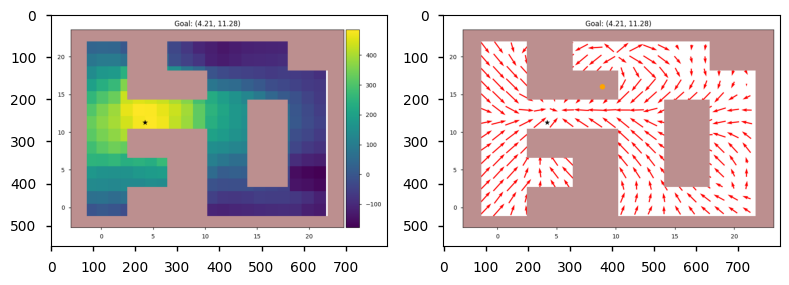

KeyboardInterrupt: 

In [ ]:
from envs.ogbench.ant_utils import policy_image, value_image
from functools import partial
from utils.evaluation import evaluate, flatten, supply_rng

pbar = tqdm(range(100_000))
env_num = 0
for step in pbar:
    key = jax.random.fold_in(GLOBAL_KEY, step)
    batch = gc_whole_dataset.sample(512)
    fb_agent, update_info = fb_agent.update(batch)

    if step % 5_000 == 0:
        env = gymnasium.make("pointmaze-medium-layout2", render_mode='rgb_array')
        env = MazeVizWrapper(env)
        
        fig, ax = plt.subplots(nrows=2, ncols=2)
        observation, info = env.reset(options=dict(task_id=3, render_goal=True))
        goal = info.get('goal')
        start = env.unwrapped.get_xy()
        latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
        
        N, M = 14, 20
        latent_z = np.tile(latent_z, (N * M, 1))
        pred_value_img = value_image(env, example_batch, N=N, M=M,
                                    value_fn=partial(fb_agent.predict_q, z=latent_z),
                                    action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                                    goal=goal)
        pred_policy_img = policy_image(env, example_batch, N=N, M=M,
                                    action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                                    goal=goal, start=start)
        
        ax[0, 0].imshow(pred_value_img)
        ax[1, 0].imshow(pred_policy_img)
        
        env = gymnasium.make("pointmaze-medium-layout1", render_mode='rgb_array')
        env = MazeVizWrapper(env)
        
        goal = info.get('goal')
        start = env.unwrapped.get_xy()
        latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
        
        N, M = 14, 20
        latent_z = np.tile(latent_z, (N * M, 1))
        pred_value_img = value_image(env, example_batch, N=N, M=M,
                                    value_fn=partial(fb_agent.predict_q, z=latent_z),
                                    action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                                    goal=goal)
        pred_policy_img = policy_image(env, example_batch, N=N, M=M,
                                    action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                                    goal=goal, start=start)
        
        ax[0, 0].imshow(pred_value_img)
        ax[1, 0].imshow(pred_policy_img)
        
        plt.tight_layout()
        display(fig)
        plt.close(fig)

In [53]:
from envs.ogbench.ant_utils import policy_image, value_image
from functools import partial
from utils.evaluation import evaluate, evaluate_fourrooms, flatten, supply_rng

env = gymnasium.make("pointmaze-medium-layout2", render_mode='rgb_array')
env = MazeVizWrapper(env)

observation, info = env.reset(options=dict(task_id=2, render_goal=True))
goal = info.get('goal')
start = env.unwrapped.get_xy()
latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
N, M = 14, 20
latent_z = np.tile(latent_z, (N * M, 1))
pred_value_img = value_image(env, example_batch, N=N, M=M,
                            value_fn=partial(fb_agent.predict_q, z=latent_z),
                            action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                            goal=goal)
pred_policy_img = policy_image(env, example_batch, N=N, M=M,
                            action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                            goal=goal, start=start)

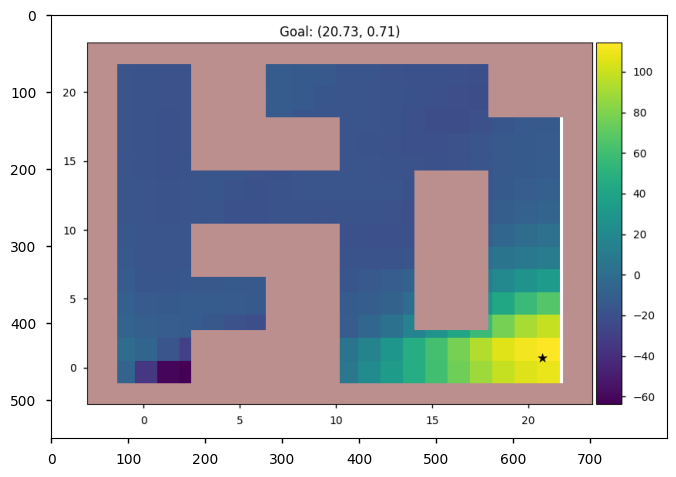

In [54]:
plt.imshow(pred_value_img)